# **Preprocess Data and Create Labels and Features**


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [2]:
DATA_PATH = os.path.join('Dataset_0')

actions = np.array(["Stop", "Maju", "Mundur", "Kanan", "Kiri"
                    ])
sequence_length = 50

In [3]:

label_map = {label: num for num, label in enumerate(actions)}
label_map

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(
                sequence), "{}-norm.npy".format(frame_num)))

            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(250, 50, 108)

In [4]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(175, 50, 108)
(75, 50, 108)
(175, 5)
(75, 5)


# **Build and Train LSTM Neural Network**


In [5]:
checkpoint = ModelCheckpoint('hand_ges_2.keras', monitor='categorical_accuracy', verbose=1,
                             mode='max', save_best_only=True, save_weights_only=False, save_freq='epoch')

In [6]:
model = Sequential()

model.add(TimeDistributed(
    Dense(units=128, activation='tanh'), input_shape=(30, 108)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()

d:\TA\.venv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 128)        │        13,952 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,245 (813.46 KB)

 Trainable params: 208,245 (813.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/45
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.2855 - loss: 1.5137
Epoch 1: categorical_accuracy improved from -inf to 0.30857, saving model to hand_ges_2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - categorical_accuracy: 0.2888 - loss: 1.5079 - val_categorical_accuracy: 0.5333 - val_loss: 1.3099
Epoch 2/45
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.4013 - loss: 1.3488
Epoch 2: categorical_accuracy improved from 0.30857 to 0.45143, saving model to hand_ges_2.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.4156 - loss: 1.3285 - val_categorical_accuracy: 0.5200 - val_loss: 1.1580
Epoch 3/45
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.3731 - loss: 1.2370
Epoch 3: categorical_accuracy did not improve from 0.45143
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - categorical_accuracy: 0.3775 - loss: 1.2296 - val_categorical_accuracy: 0.7333 - val_loss: 1.0659
Epoch 4/45
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 

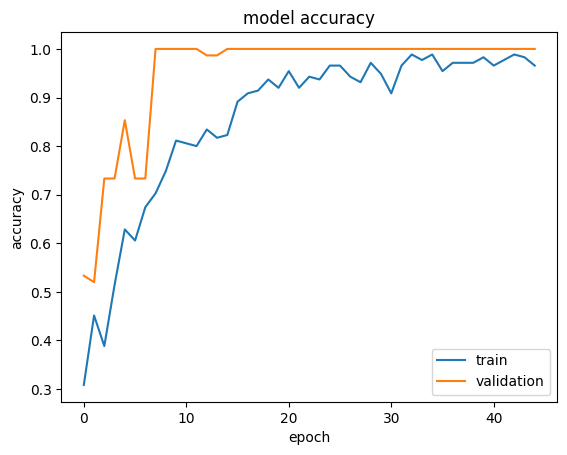

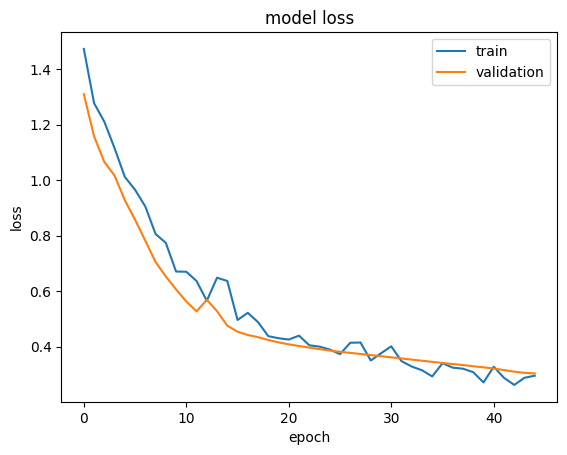

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 128)        │        13,952 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,737 (2.38 MB)

 Trainable params: 208,245 (813.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 416,492 (1.59 MB)

In [7]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
train_model = model.fit(X_train, y_train, epochs=45, callbacks=[
                        checkpoint], validation_data=(X_test, y_test))

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

model.summary()

In [624]:
# plot_model(model, to_file="model1.png", show_shapes=True)

# **Save Weights**


In [8]:
number_of_classes = len(actions)
current_date = '10042024'  # changes manually
version = 1

model_filename = "model/model_" + \
    str(number_of_classes) + '_' + 'lstm' + '_' + \
    current_date + '_' + str(version) + ".h5"

print(model_filename)

model.save(model_filename)
model.load_weights(model_filename)

model/model_5_lstm_10042024_1.h5


# **Evaluation using Confusion Matrix and Accuracy**


In [10]:
yhat = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [11]:
print(actions[np.argmax(yhat[2])])
print(actions[np.argmax(y_test[2])])

Stop
Stop


In [12]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [13]:
from sklearn.metrics import classification_report

report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

        Stop       1.00      1.00      1.00        15
        Maju       1.00      1.00      1.00        20
      Mundur       1.00      1.00      1.00         9
       Kanan       1.00      1.00      1.00        15
        Kiri       1.00      1.00      1.00        16

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



In [14]:
# mcm = multilabel_confusion_matrix(ytrue, yhat)
# print(mcm)

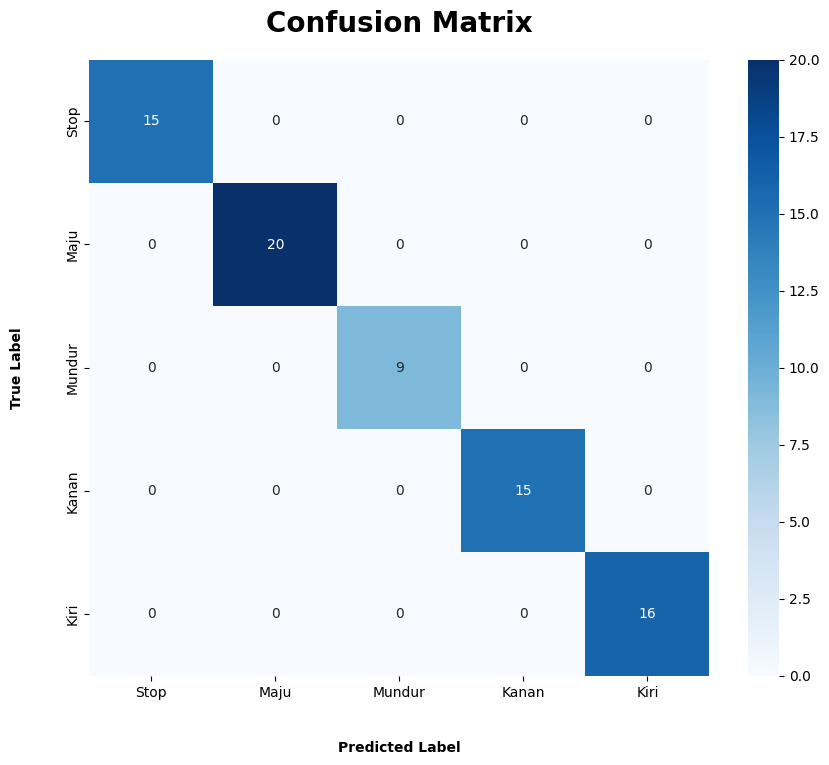

In [15]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d',
                      cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [16]:
from sklearn.metrics import precision_recall_fscore_support

metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i]))
                      for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: Stop
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Maju
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Mundur
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Kanan
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Kiri
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Stop
Accuracy: 1.0

Class: Maju
Accuracy: 1.0

Class: Mundur
Accuracy: 1.0

Class: Kanan
Accuracy: 1.0

Class: Kiri
Accuracy: 1.0

